# DS7333 Case Study 
##  Naive Bayes and Clustering

#### John Girard, Shijo Joseph, Douglas Yip

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import email
from bs4 import BeautifulSoup as BS4

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [3]:
count = 0
dir_count = 0
for root_dir, cur_dir, files in os.walk(".\\SpamAssassinMessages"):
    dir_count = len(files)
    count += len(files)
    for names in cur_dir:
        print(names, len(os.listdir(os.path.join(root_dir, names))))
print('Total Files:', count)

easy_ham 5052
easy_ham_2 1401
hard_ham 501
spam 1001
spam_2 1398
Total Files: 9353


In [4]:
os.listdir(".\\SpamAssassinMessages")

['easy_ham', 'easy_ham_2', 'hard_ham', 'spam', 'spam_2']

In [5]:
file_name = []
contents = []
types = []
labels = []
labelnames = []
message = ''

for root, dirs, files in os.walk(".\\SpamAssassinMessages"):
    for name in files:
        with open(os.path.join(root, name),
                  'r', encoding='latin1') as f:
            message = ''
            try:
                x = email.message_from_file(f)
            except UnicodeDecodeError:
                print("Error in file: Unknown Error")
            if "multipart" in x.get_content_type():
                if x.is_multipart():
                    for part in x.get_payload():
                        message = message + part.as_string()
                contents.append(message.replace("\n", " ")
                                .replace(r'http\S+', ' ')
                                .replace("-", " "))
            elif "text/plain" in x.get_content_type():
                contents.append(x.get_payload()
                                .replace("\n", " ")
                                .replace(r'http\S+', ' ')
                                .replace("-", " "))
            elif "text/html" in x.get_content_type():
                contents.append(BS4(x.get_payload())
                                .get_text()
                                .replace(r'http\S+', ' ')
                                .replace("\n", " ")
                                .replace("-", " "))
            types.append(x.get_content_type())
            if "ham" in root:
                labelnames.append('ham')
                labels.append(1)
            elif "spam" in root:
                labelnames.append('spam')
                labels.append(0)
            file_name.append(os.path.join(root, name))

In [6]:
types = pd.DataFrame(types)
types.shape
types.value_counts()

text/plain                     7413
text/html                      1193
multipart/alternative           326
multipart/signed                180
multipart/mixed                 179
multipart/related                56
multipart/report                  5
text/plain charset=us-ascii       1
dtype: int64

In [7]:
df_NB = pd.DataFrame()
df_NB['Filename'] = file_name
df_NB['types'] = types
df_NB['email_body'] = contents
df_NB['labelnames'] = labelnames
df_NB['labels'] = labels

In [8]:
df_NB

,Filename,types,email_body,labelnames,labels
0,.\SpamAssassinMessages\easy_ham\00001.7c53336b...,text/plain,"Date: Wed, 21 Aug 2002 10:54:46 05...",ham,1
1,.\SpamAssassinMessages\easy_ham\00002.9c4069e2...,text/plain,"Martin A posted: Tassos Papadopoulos, the Gree...",ham,1
2,.\SpamAssassinMessages\easy_ham\00003.860e3c3c...,text/plain,Man Threatens Explosion In Moscow Thursday A...,ham,1
3,.\SpamAssassinMessages\easy_ham\00004.864220c5...,text/plain,Klez: The Virus That Won't Die Already the m...,ham,1
4,.\SpamAssassinMessages\easy_ham\00005.bf27cdea...,text/plain,"> in adding cream to spaghetti carbonara, whi...",ham,1
...,...,...,...,...,...
9348,.\SpamAssassinMessages\spam_2\01397.f75f0dd0dd...,multipart/alternative,"Content Type: text/plain; \tcharset=""Windows 1...",spam,0
9349,.\SpamAssassinMessages\spam_2\01398.8ca7045aae...,text/plain,"Dear Subscriber, If I could show you a way to...",spam,0
9350,.\SpamAssassinMessages\spam_2\01399.2319643317...,text/plain,****Mid Summer Customer Appreciation SALE!****...,spam,0
9351,.\SpamAssassinMessages\spam_2\01400.b444b69845...,text/plain,ATTN:SIR/MADAN ST...,spam,0


In [9]:
the_count = CountVectorizer()
Xtrain = the_count.fit_transform(df_NB['email_body'])
Xtrain = Xtrain.toarray()

In [10]:
# calculate distortion for a range of number of cluster
distortions = []
best_distortion = 10000
best_i = 10
for i in range(1, 30):
    km = KMeans(n_clusters=i,
                n_init='auto',
                random_state=0)
    km.fit(Xtrain)
    distortions.append(km.inertia_)
    if best_distortion > km.inertia_:
        best_distortion = km.inertia_
        best_i = i
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [11]:
print("Best i  found:")
print(best_i)
print("Best distortion  found:")
print(best_distortion)

Best i  found:
10
Best distortion  found:
10000


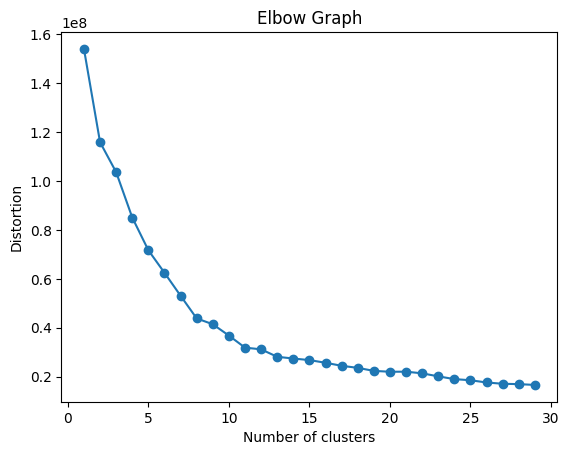

In [12]:
# plot the data
plt.plot(range(1, 30), distortions, marker='o')
plt.title("Elbow Graph")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [13]:
km = KMeans(n_clusters=11,
            n_init='auto',
            random_state=0)
clusters = km.fit_predict(Xtrain)

In [14]:
df_NB['clusters'] = clusters

In [15]:
df_NB

,Filename,types,email_body,labelnames,labels,clusters
0,.\SpamAssassinMessages\easy_ham\00001.7c53336b...,text/plain,"Date: Wed, 21 Aug 2002 10:54:46 05...",ham,1,0
1,.\SpamAssassinMessages\easy_ham\00002.9c4069e2...,text/plain,"Martin A posted: Tassos Papadopoulos, the Gree...",ham,1,0
2,.\SpamAssassinMessages\easy_ham\00003.860e3c3c...,text/plain,Man Threatens Explosion In Moscow Thursday A...,ham,1,0
3,.\SpamAssassinMessages\easy_ham\00004.864220c5...,text/plain,Klez: The Virus That Won't Die Already the m...,ham,1,0
4,.\SpamAssassinMessages\easy_ham\00005.bf27cdea...,text/plain,"> in adding cream to spaghetti carbonara, whi...",ham,1,0
...,...,...,...,...,...,...
9348,.\SpamAssassinMessages\spam_2\01397.f75f0dd0dd...,multipart/alternative,"Content Type: text/plain; \tcharset=""Windows 1...",spam,0,3
9349,.\SpamAssassinMessages\spam_2\01398.8ca7045aae...,text/plain,"Dear Subscriber, If I could show you a way to...",spam,0,0
9350,.\SpamAssassinMessages\spam_2\01399.2319643317...,text/plain,****Mid Summer Customer Appreciation SALE!****...,spam,0,7
9351,.\SpamAssassinMessages\spam_2\01400.b444b69845...,text/plain,ATTN:SIR/MADAN ST...,spam,0,0


In [16]:
type(Xtrain)

numpy.ndarray

In [17]:
Xtrain.shape

(9353, 125639)

In [18]:
New_Xtrain = np.hstack((Xtrain, clusters.reshape(-1, 1)))
New_Xtrain.shape

(9353, 125640)

In [19]:
cluster_array = np.array(df_NB['clusters'])
cluster_array.shape

(9353,)

### Naive Bayes Portion

##### Using Count Vectorizer

In [20]:
# Import Naive Bayes

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [21]:
training_data, testing_data = \
    train_test_split(df_NB, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 7482
No. of testing examples: 1871


In [22]:
the_count = CountVectorizer(ngram_range=(1, 2))

Xtrain = the_count.fit_transform(training_data['email_body'])

In [23]:
Xtrain = Xtrain.toarray()

In [24]:
# Fit Naive Bayes model
nb = MultinomialNB(alpha=0.1)
nb.fit(Xtrain, training_data['labels'])

MultinomialNB(alpha=0.1)

In [25]:
Xtest = the_count.transform(testing_data['email_body'])
preds = nb.predict(Xtest.toarray())

In [26]:
preds.shape

(1871,)

In [27]:
print(classification_report(testing_data['labels'], preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       480
           1       0.99      0.99      0.99      1391

    accuracy                           0.99      1871
   macro avg       0.99      0.98      0.99      1871
weighted avg       0.99      0.99      0.99      1871



In [28]:
# plot the confusion matrix

cnf_matrix = confusion_matrix(testing_data['labels'], preds)

print(cnf_matrix)

[[ 466   14]
 [   7 1384]]


##### Using TF-IDF Vectorizor

In [29]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))

Xtrain = tfidf.fit_transform(training_data['email_body'])

In [30]:
Xtrain = Xtrain.toarray()

In [31]:
# Fit Naive Bayes model
nb = MultinomialNB(alpha=0.1)
nb.fit(Xtrain, training_data['labels'])

MultinomialNB(alpha=0.1)

In [32]:
Xtest = tfidf.transform(testing_data['email_body'])
preds = nb.predict(Xtest.toarray())

In [33]:
preds.shape

(1871,)

In [34]:
print(classification_report(testing_data['labels'], preds))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       480
           1       0.98      1.00      0.99      1391

    accuracy                           0.98      1871
   macro avg       0.98      0.97      0.98      1871
weighted avg       0.98      0.98      0.98      1871



In [35]:
# plot the confusion matrix

cnf_matrix = confusion_matrix(testing_data['labels'], preds)

print(cnf_matrix)

[[ 451   29]
 [   6 1385]]


In [36]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 1, 10],
}

clf2 = GridSearchCV(text_clf, parameters, cv=5)
clf2.fit(training_data['email_body'], training_data['labels'])

print("Best parameters set found on development set:")
print(clf2.best_params_)

preds = clf2.predict(testing_data['email_body'])
print(classification_report(testing_data['labels'], preds))

cnf2_matrix = confusion_matrix(testing_data['labels'], preds)
print(cnf2_matrix)

Best parameters set found on development set:
{'clf__alpha': 0.1, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       480
           1       0.99      0.99      0.99      1391

    accuracy                           0.99      1871
   macro avg       0.99      0.98      0.99      1871
weighted avg       0.99      0.99      0.99      1871

[[ 466   14]
 [   7 1384]]


In [37]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 1, 10],
}

clf2 = GridSearchCV(text_clf, parameters, cv=5)
clf2.fit(training_data['email_body'], training_data['labels'])

print("Best parameters set found on development set:")
print(clf2.best_params_)

preds = clf2.predict(testing_data['email_body'])
print(classification_report(testing_data['labels'], preds))

cnf2_matrix = confusion_matrix(testing_data['labels'], preds)
print(cnf2_matrix)

Best parameters set found on development set:
{'clf__alpha': 0.1, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       480
           1       0.98      1.00      0.99      1391

    accuracy                           0.98      1871
   macro avg       0.98      0.97      0.98      1871
weighted avg       0.98      0.98      0.98      1871

[[ 451   29]
 [   6 1385]]


In [38]:
def prediction(df):
    count = CountVectorizer(ngram_range=(1, 2))
    clf = MultinomialNB(alpha=0.1)
    training_data, testing_data = \
        train_test_split(df, test_size=0.2, random_state=25)
    Xtrain = count.fit_transform(training_data['email_body'])
    Xtrain = Xtrain.toarray()
    cluster_array = np.array(training_data['clusters'])
    Xtrain2 = np.hstack((Xtrain, cluster_array.reshape(-1, 1)))
    clf.fit(Xtrain2, training_data['labels'])
    Xtest = count.transform(testing_data['email_body'])
    Xtest = Xtest.toarray()
    cluster_array = np.array(testing_data['clusters'])
    Xtest2 = np.hstack((Xtest, cluster_array.reshape(-1, 1)))
    preds = clf.predict(Xtest2)
    return print(classification_report(testing_data['labels'], preds))

In [39]:
def create_df_from_file(path):
    file_name = []
    contents = []
    types = []
    labels = []
    labelnames = []
    message = ''
    for root, dirs, files in os.walk(path):
        for name in files:
            with open(os.path.join(root, name),
                      'r', encoding='latin1') as f:
                message = ''
                try:
                    x = email.message_from_file(f)
                except UnicodeDecodeError:
                    print("Error in file: Unknown Error")
                if "multipart" in x.get_content_type():
                    if x.is_multipart():
                        for part in x.get_payload():
                            message = message + part.as_string()
                    contents.append(message.replace("\n", " ")
                                    .replace(r'http\S+', ' ')
                                    .replace("-", " "))
                elif "text/plain" in x.get_content_type():
                    contents.append(x.get_payload()
                                    .replace("\n", " ")
                                    .replace(r'http\S+', ' ')
                                    .replace("-", " "))
                elif "text/html" in x.get_content_type():
                    contents.append(BS4(x.get_payload())
                                    .get_text()
                                    .replace(r'http\S+', ' ')
                                    .replace("\n", " ")
                                    .replace("-", " "))
                types.append(x.get_content_type())
                if "ham" in root:
                    labelnames.append('ham')
                    labels.append(1)
                elif "spam" in root:
                    labelnames.append('spam')
                    labels.append(0)
                file_name.append(os.path.join(root, name))
    df_NB = pd.DataFrame()
    df_NB['Filename'] = file_name
    df_NB['types'] = types
    df_NB['email_body'] = contents
    df_NB['labelnames'] = labelnames
    df_NB['labels'] = labels
    the_count = CountVectorizer()
    Xtrain = the_count.fit_transform(df_NB['email_body'])
    Xtrain = Xtrain.toarray()
    km = KMeans(n_clusters=11,
                n_init='auto',
                random_state=0)
    clusters = km.fit_predict(Xtrain)
    df_NB['clusters'] = clusters
    return df_NB

In [40]:
New_df = create_df_from_file(".\\SpamAssassinMessages")
New_df

,Filename,types,email_body,labelnames,labels,clusters
0,.\SpamAssassinMessages\easy_ham\00001.7c53336b...,text/plain,"Date: Wed, 21 Aug 2002 10:54:46 05...",ham,1,0
1,.\SpamAssassinMessages\easy_ham\00002.9c4069e2...,text/plain,"Martin A posted: Tassos Papadopoulos, the Gree...",ham,1,0
2,.\SpamAssassinMessages\easy_ham\00003.860e3c3c...,text/plain,Man Threatens Explosion In Moscow Thursday A...,ham,1,0
3,.\SpamAssassinMessages\easy_ham\00004.864220c5...,text/plain,Klez: The Virus That Won't Die Already the m...,ham,1,0
4,.\SpamAssassinMessages\easy_ham\00005.bf27cdea...,text/plain,"> in adding cream to spaghetti carbonara, whi...",ham,1,0
...,...,...,...,...,...,...
9348,.\SpamAssassinMessages\spam_2\01397.f75f0dd0dd...,multipart/alternative,"Content Type: text/plain; \tcharset=""Windows 1...",spam,0,3
9349,.\SpamAssassinMessages\spam_2\01398.8ca7045aae...,text/plain,"Dear Subscriber, If I could show you a way to...",spam,0,0
9350,.\SpamAssassinMessages\spam_2\01399.2319643317...,text/plain,****Mid Summer Customer Appreciation SALE!****...,spam,0,7
9351,.\SpamAssassinMessages\spam_2\01400.b444b69845...,text/plain,ATTN:SIR/MADAN ST...,spam,0,0


In [41]:
prediction(New_df)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       480
           1       0.99      0.99      0.99      1391

    accuracy                           0.99      1871
   macro avg       0.99      0.98      0.99      1871
weighted avg       0.99      0.99      0.99      1871

